In [2]:
import casadi as cs
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

Lade das statische Modell

In [26]:
stat_model = pkl.load(open('stat_model.pkl','rb') )
f_model = stat_model['f_model']
theta_opt = stat_model['theta_opt']

Ziel ist, die Eingangsgrößen $\boldsymbol{u}$ so zu bestimmen, dass die Differenz zwischen einem Referenzwert der Ausgangsgröße $y_{\mathrm{ref}}$ und der vom Modell gschätzten Ausgangsgröße $\hat{y}$ minimiert wird. Die funktionale Abhängigkeit zwischen Eingangsgrößen $\boldsymbol{u}$ und einem Referenzwert der Ausgangsgröße $y_{\mathrm{ref}}$ auf der einen Seite und der resultierende Abweichung zwischen Referenzwert und Modellprädiktion ist Zielfunktion den Optimierungsproblems und kann als CasADi-Funktion implementiert werden:

In [32]:
u = cs.MX.sym('u',2,1)
y_ref = cs.MX.sym('y_ref',1,1)

L = (y_ref - f_model(u=u,theta=theta_opt)['y'])**2

L = cs.Function('L',[u,y_ref],[L],['u','y_ref'],['L'])

Mittels der CasADi Opti-Klasse kann das Optimierungsproblem nun formuliert werden:

In [36]:
opti = cs.Opti() # 
u = opti.variable(2,1) #

opti.minimize(L(u=u,y_ref=0.5)['L'])

opti.solver('ipopt')
sol = opti.solve()


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        3

Total number of variables............................:        2
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 2

In [37]:
u_opt = sol.value(u)
print(u_opt)

Das Optimierungsproblem ist allerdings nichtlinear (siehe Plot) und damit abhängig von den Initialisierungswerten für $\boldsymbol{u}_{\mathrm{opt}}$. Das Optimierungsproblem muss daher mehrmals für unterschiedliche Startwerte gelöst werden oder die Lösung durch einführen von Randbedingungen eindeutig gemacht werden:

In [42]:
opti.subject_to(u[0]>-2)
opti.subject_to(u[0]<2)

opti.subject_to(u[1]>-2)
opti.subject_to(u[1]<2)

init = [[-2,-2],[-2,2],[2,-2],[2,2]]

u_opt = []
for i in init:
    opti.set_initial(u,i)
    sol = opti.solve()
    u_opt.append(sol.value(u))

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        4
Number of nonzeros in Lagrangian Hessian.............:        3

Total number of variables............................:        2
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        4
        inequality constraints with only lower bounds:        2
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        2

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 4

In [145]:
y_opt = [f_model(u = u,theta=theta_opt)['y'] for u in u_opt]

In [154]:
opt = np.hstack([np.array(u_opt),np.array(y_opt).reshape((4,1))])

In [129]:
D = pkl.load(open('static_data.pkl','rb'))
y_est = [f_model(u = D.loc[k,['u1','u2']],theta=theta_opt)['y'] for k in D.index]
y_est = np.array(y_est).reshape((-1,1))

[(-0.5, 2.0), (-0.5, 2.0)]

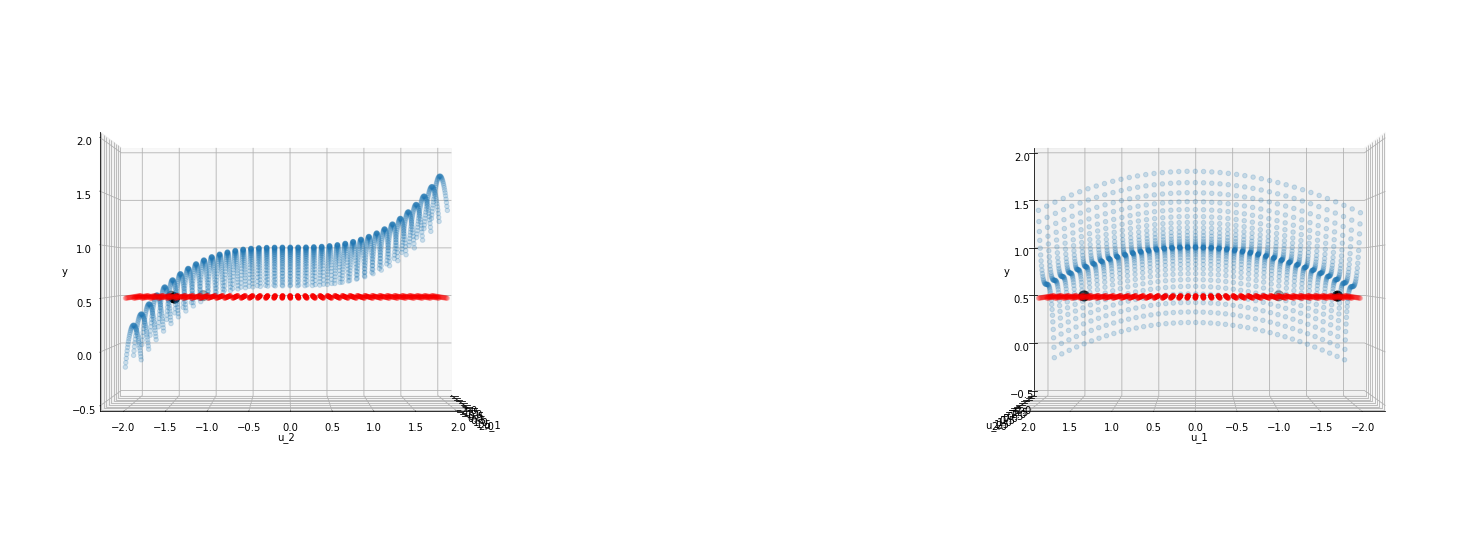

In [170]:
fig,ax = plt.subplots(1,2,subplot_kw={'projection': '3d'})
fig.set_size_inches((30,10))
ax[0].elev = 0 # Höhe der Betrachung
ax[0].azim = 0 # Neigungswinkel der Betrachtung

ax[1].elev = 0 # Höhe der Betrachung
ax[1].azim = 90 # Neigungswinkel der Betrachtung

[a.scatter(D['u1'],D['u2'],y_est,alpha=0.2) for a in ax]
[a.scatter(D['u1'],D['u2'],[0.5]*len(D),alpha=0.1,color='r') for a in ax]

[a.scatter(opt[:,0],opt[:,1],opt[:,2],color='k',s=100)  for a in ax]

[a.set_xlabel('u_1') for a in ax]
[a.set_ylabel('u_2') for a in ax]
[a.set_zlabel('y') for a in ax]
[a.set_zlim([-0.5,2]) for a in ax]


In [166]:
opt

array([[-1.10538976, -1.55929139,  0.49999975],
       [-1.86572733, -1.16240995,  0.5       ],
       [ 1.47148526, -1.42638702,  0.49999943],
       [ 1.48371452, -1.41993587,  0.49999967]])

In [169]:
f_model(u = [-1.1,-1.5],theta=theta_opt)

{'y': DM(0.541446)}